In [20]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from utils_SA import simulate_model
import pypesto
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import matplotlib.pyplot as plt
import time
import json

In [21]:
from inputFactorSpace import input_factor_names, df_input_factors

In [22]:
df_input_factors.head()

,Short,ot dist,bounds,lower_bounds,upper_bounds,Age-dep,Group,Category,fix_by_vi
Name,,,,,,,,,
dummy,d,"Uniform(a = 0, b = 1)","[0.0, 1.0]",0.00,1.00,False,dummy,helper,True
incubation_time,$t_{\textnormal{inc}}$,"Uniform(a = 4.1, b = 7)","[4.1, 7.0]",4.10,7.00,False,incubation_time,virus related,True
serial_interval,$t_{\textnormal{serint}}$,"Uniform(a = 0.63, b = 0.87)","[0.63, 0.87]",0.63,0.87,False,serial_interval,virus related,False
infectious_mild_time,$T_I^R$,"Uniform(a = 5.6, b = 8.4)","[5.6, 8.4]",5.60,8.40,False,infectious_mild_time,transition time,True
hospitalized_to_ICU_time,$T_H^U$,"Uniform(a = 3, b = 7)","[3.0, 7.0]",3.00,7.00,False,hospitalized_to_ICU_time,transition time,True


In [23]:
path_data = 'data/worldometer_data.txt'

# Define Comartment names
compartments = ['susceptible', 'exposed', 'carrier', 'infected', 'hospitalized', 'icu', 'recovered', 'dead']
Compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 50 # number of days to simulate
output_index = 7

start_day = 18
start_month = 3
start_year = 2020
starting_day = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

static_params = {
    'num_groups': num_groups, 
    'num_compartments': num_compartments,
    'populations': populations,
    'start_day' : (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days,
    'days' : days,
    'dt' : dt,
    # which compartment's value should be outputed?
    'output_index' : output_index #compartments.index("Dead")
}

In [26]:
# load data
data_dict = {}
with open(path_data) as f:
    lines = f.readlines()
    #data_dict.update(lines[0])
    print(lines[-1])
    for i in range(len(lines)-1):
        (key, value) = lines[i].split(":")
        value = json.loads(value)
        data_dict[key] = value
print(data_dict.keys())

start_dataset = 32
number_of_days = days
print(data_dict['categories'][start_dataset])
print(start_year, start_month, start_day)

# when used for a different time period, initial numbers must be matched first. 
# Saved simulation is from start day 0, therefore no initial numbers in Hospitalized, Infected and Recovered
# Divide by 100 because of the population size used in the model
#dataset = np.zeros((number_of_days+1, 2))
#dataset[:, 0] = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0
#dataset[:, 1] = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0

dead_cases = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0
infected_cases = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0

# load file for parameter importance and add to input factor dataframe
df_fixing = pd.read_csv('results/dgsm_vi_important.csv', index_col = 0)
df_input_factors['fix_by_vi']=[df_fixing.loc[name, 'vi'] for name in input_factor_names]
#df_input_factors = df_input_factors.set_index('Name', drop = True)

source : "https://www.worldometers.info/coronavirus/country/germany/#graph-deaths-daily"

dict_keys(['categories', 'currently_infected', 'total_deaths', 'new_recoveries'])
Mar 18, 2020
2020 3 18


In [27]:
def fix_factors(df_input_factors, column_to_fix = 'fix_by_vi', fixed_value = 'mean'):
    dict_fixed_factors = {}
    if fixed_value == 'mean':
        dict_fixed_factors = df_input_factors[df_input_factors[column_to_fix]].loc[:, 'ot dist'].apply(lambda x : x.getMean()[0]).to_dict()
    if fixed_value == 'random':
        df_input_factors[df_input_factors[column_to_fix]].loc[:, 'ot dist'].apply(lambda x : float(np.array(x.getSample(1)))).to_dict()
    lower_bounds = list(df_input_factors[df_input_factors[column_to_fix] == False].loc[:, 'lower_bounds'].values)
    upper_bounds = list(df_input_factors[df_input_factors[column_to_fix] == False].loc[:, 'upper_bounds'].values)
    varying_input_factors = list(df_input_factors[df_input_factors[column_to_fix] == False].index)
    return dict_fixed_factors, lower_bounds, upper_bounds, varying_input_factors

In [28]:
dict_fixed_factors, lower_bounds, upper_bounds, varying_input_factors = fix_factors(df_input_factors, column_to_fix = 'fix_by_vi', fixed_value = 'mean')

In [29]:
def simulate_model_logParam(theta, 
                            param_names = varying_input_factors, 
                            static_params = static_params,
                            fixed_factors = dict_fixed_factors):
    '''
    Call the model simulation for given log-transformed 
    values (theta) for the parameters listed in param_names. 
    The static parameters include all other parameters that are not
    subject to the optimization.
    '''
    theta = np.exp(theta)
    if fixed_factors is None:
        result = simulate_model({**static_params, **dict(zip(param_names, theta))})
    else:
        result = simulate_model({**static_params, **dict(zip(param_names, theta)), **fixed_factors})
    return result


# TODO: change noise model
def neg_log_likelihood_logParam(theta, measurement = infected_cases):
    sigma = theta[0]
    simulation = simulate_model_logParam(theta[1:])
    simulation = np.cumsum(simulation)
    nllh = np.log(2*np.pi*sigma**2)+((measurement-simulation)/sigma)**2
    nllh = 0.5*sum(nllh)
    return nllh

def neg_binomial_log_likelihood():
    '''
    Discrete distribution that models nb of successes in a sequence of iid Bernoulli trials
    before r predefinded events (failures) occur. 
    Suitable if used to model the nb of infected/ pos. tested individuals as the event rate
    is known but the number of test is usually not.
    (Bernoulli trials: COVID tests, success: negative test, failure: positive test)
    r > 0 (int): number of failures until the experiment is stopped
    p in [0, 1] (float): success probability in each experiment
    '''
    return


In [30]:
#----------------------------------------------------------------------------------------------------------------------------------------------

objective1 = pypesto.Objective(
    fun=neg_log_likelihood_logParam,
)

# set upper and lower bound
#lb = np.array([1e-3] + [50, 25, 10, 10, 1e-3, 1e-3, 1e-3] + [3, 1, 1, 1, 1, 1] + [0.1, 0.6, 0.05, 0.01, 0.1, 0.15, 0.15, 1])
#ub = np.array([1] + [150, 75, 30, 30, 20, 20, 1] + [7, 15, 15, 15, 15, 15] + [ 0.9, 1.0, 0.5, 0.16, 0.35, 0.4, 0.77, 3])

lb = np.array([1e-5] + lower_bounds)
lb = np.where(lb <= 0, 1e-9, lb)
ub = np.array([1] + upper_bounds)#+1e-9 

lb = np.log(lb)
ub = np.log(ub)

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)

# create different optimizers
optimizer_bfgs = optimize.ScipyOptimizer(method="l-bfgs-b")
optimizer_tnc = optimize.ScipyOptimizer(method="TNC")

# set number of starts
n_starts = 15
# save optimizer trace
history_options = pypesto.HistoryOptions(trace_record=True)
'''
start = time.time()
# Run optimizaitons for different optimzers
# result1_bfgs = optimize.minimize(
#     problem=problem1,
#     optimizer=optimizer_bfgs,
#     n_starts=n_starts,
#     history_options=history_options,
#     filename=None,
# )

result1_tnc = optimize.minimize(
    problem=problem1,
    optimizer=optimizer_tnc,
    n_starts=n_starts,
    history_options=history_options,
    filename='logs/'+ time.strftime("%Y-%m-%d %H%M%S") + '_optimizer_log.hdf5',
)

end = time.time()

'''


'\nstart = time.time()\n# Run optimizaitons for different optimzers\n# result1_bfgs = optimize.minimize(\n#     problem=problem1,\n#     optimizer=optimizer_bfgs,\n#     n_starts=n_starts,\n#     history_options=history_options,\n#     filename=None,\n# )\n\nresult1_tnc = optimize.minimize(\n    problem=problem1,\n    optimizer=optimizer_tnc,\n    n_starts=n_starts,\n    history_options=history_options,\n    filename=\'logs/\'+ time.strftime("%Y-%m-%d %H%M%S") + \'_optimizer_log.hdf5\',\n)\n\nend = time.time()\n\n'

In [31]:

path_data = 'data/worldometer_data.txt'

# Define Comartment names
compartments = ['susceptible', 'exposed', 'carrier', 'infected', 'hospitalized', 'icu', 'recovered', 'dead']
Compartments = ['Susceptible', 'Exposed', 'Carrier', 'Infected', 'Hospitalized', 'ICU', 'Recovered', 'Dead']
# Define age Groups
groups = ['0-4', '5-14', '15-34', '35-59', '60-79', '80+']
# Define population of age groups
populations = [40000, 70000, 190000, 290000, 180000, 60000] 

days = 50 # number of days to simulate
output_index = 3

start_day = 18
start_month = 3
start_year = 2020
starting_day = (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days
dt = 0.1
num_groups = len(groups)
num_compartments = len(compartments)

static_params = {
    'num_groups': num_groups, 
    'num_compartments': num_compartments,
    'populations': populations,
    'start_day' : (date(start_year, start_month, start_day) - date(start_year, 1, 1)).days,
    'days' : days,
    'dt' : dt,
    # which compartment's value should be outputed?
    'output_index' : output_index #compartments.index("Dead")
}

# load data
data_dict = {}
with open(path_data) as f:
    lines = f.readlines()
    #data_dict.update(lines[0])
    print(lines[-1])
    for i in range(len(lines)-1):
        (key, value) = lines[i].split(":")
        value = json.loads(value)
        data_dict[key] = value
print(data_dict.keys())

start_dataset = 32
number_of_days = days
print(data_dict['categories'][start_dataset])
print(start_year, start_month, start_day)

# when used for a different time period, initial numbers must be matched first. 
# Saved simulation is from start day 0, therefore no initial numbers in Hospitalized, Infected and Recovered
# Divide by 100 because of the population size used in the model
#dataset = np.zeros((number_of_days+1, 2))
#dataset[:, 0] = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0
#dataset[:, 1] = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0

dead_cases = np.array(data_dict['total_deaths'][start_dataset:number_of_days+1+start_dataset])/100.0
infected_cases = np.array(data_dict['currently_infected'][start_dataset:number_of_days+1+start_dataset])/100.0

# load file for parameter importance and add to input factor dataframe
df_fixing = pd.read_csv('results/dgsm_vi_important.csv', index_col = 0)
df_input_factors['fix_by_vi']=[df_fixing.loc[name, 'vi'] for name in input_factor_names]
#df_input_factors = df_input_factors.set_index('Name', drop = True)

def fix_factors(df_input_factors, column_to_fix = 'fix_by_vi', fixed_value = 'mean'):
    dict_fixed_factors = {}
    if fixed_value == 'mean':
        dict_fixed_factors = df_input_factors[df_input_factors[column_to_fix]].loc[:, 'ot dist'].apply(lambda x : x.getMean()[0]).to_dict()
    if fixed_value == 'random':
        df_input_factors[df_input_factors[column_to_fix]].loc[:, 'ot dist'].apply(lambda x : float(np.array(x.getSample(1)))).to_dict()
    lower_bounds = list(df_input_factors[df_input_factors[column_to_fix] == False].loc[:, 'lower_bounds'].values)
    upper_bounds = list(df_input_factors[df_input_factors[column_to_fix] == False].loc[:, 'upper_bounds'].values)
    varying_input_factors = list(df_input_factors[df_input_factors[column_to_fix] == False].index)
    return dict_fixed_factors, lower_bounds, upper_bounds, varying_input_factors

dict_fixed_factors, lower_bounds, upper_bounds, varying_input_factors = fix_factors(df_input_factors, column_to_fix = 'fix_by_vi', fixed_value = 'mean')
# assumption that unknown cases are 3 times as much. Match infected numbers to observed.
dict_fixed_factors['init_exposed'] = infected_cases[0]
dict_fixed_factors['init_carrier'] = infected_cases[0]
dict_fixed_factors['init_infected'] = infected_cases[0]

def simulate_model_logParam(theta, 
                            param_names = varying_input_factors, 
                            static_params = static_params,
                            fixed_factors = dict_fixed_factors):
    '''
    Call the model simulation for given log-transformed 
    values (theta) for the parameters listed in param_names. 
    The static parameters include all other parameters that are not
    subject to the optimization.
    '''
    theta = np.exp(theta)
    if fixed_factors is None:
        result = simulate_model({**static_params, **dict(zip(param_names, theta))})
    else:
        result = simulate_model({**static_params, **dict(zip(param_names, theta)), **fixed_factors})
    return result


# TODO: change noise model
def neg_log_likelihood_logParam(theta, measurement = infected_cases):
    sigma = theta[0]
    simulation = simulate_model_logParam(theta[1:])
    simulation = simulation
    nllh = np.log(2*np.pi*sigma**2)+((measurement-simulation)/sigma)**2
    nllh = 0.5*sum(nllh)
    return nllh

def neg_binomial_log_likelihood():
    '''
    Discrete distribution that models nb of successes in a sequence of iid Bernoulli trials
    before r predefinded events (failures) occur. 
    Suitable if used to model the nb of infected/ pos. tested individuals as the event rate
    is known but the number of test is usually not.
    (Bernoulli trials: COVID tests, success: negative test, failure: positive test)
    r > 0 (int): number of failures until the experiment is stopped
    p in [0, 1] (float): success probability in each experiment
    '''
    return




#----------------------------------------------------------------------------------------------------------------------------------------------

objective1 = pypesto.Objective(
    fun=neg_log_likelihood_logParam,
)

source : "https://www.worldometers.info/coronavirus/country/germany/#graph-deaths-daily"

dict_keys(['categories', 'currently_infected', 'total_deaths', 'new_recoveries'])
Mar 18, 2020
2020 3 18


In [2]:

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import pypesto
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store

In [78]:
fn = 'logs/2022-09-05 120006_optimizer_result_log.hdf5'


result = store.read_result(fn, problem=True)

This problem is not to be used without a separately created objective.
Loading the profiling result failed. It is highly likely that no profiling result exists within logs/2022-09-05 120006_optimizer_result_log.hdf5.


/localdata1/lang_a4/memilio/epi_venv3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Offsetted function value (relative to best start)'>

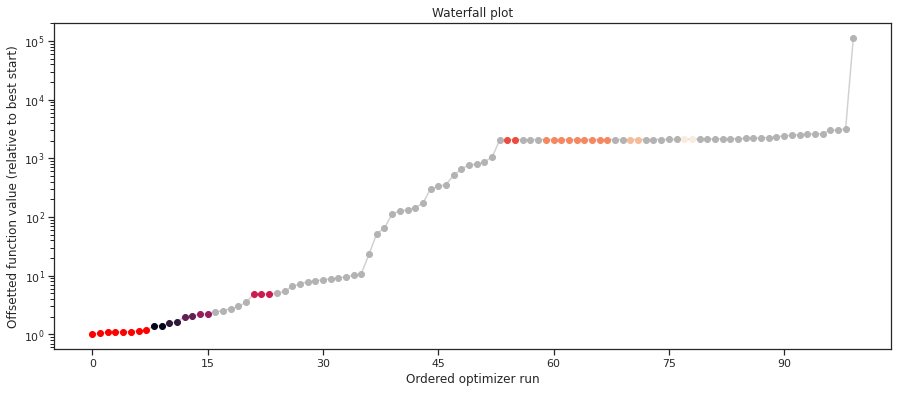

In [79]:
pypesto.visualize.waterfall(result, size=(15, 6))

In [80]:
#problem = problem.read(objective = objective1)

In [81]:
from inputFactorSpace import varying_input_factors

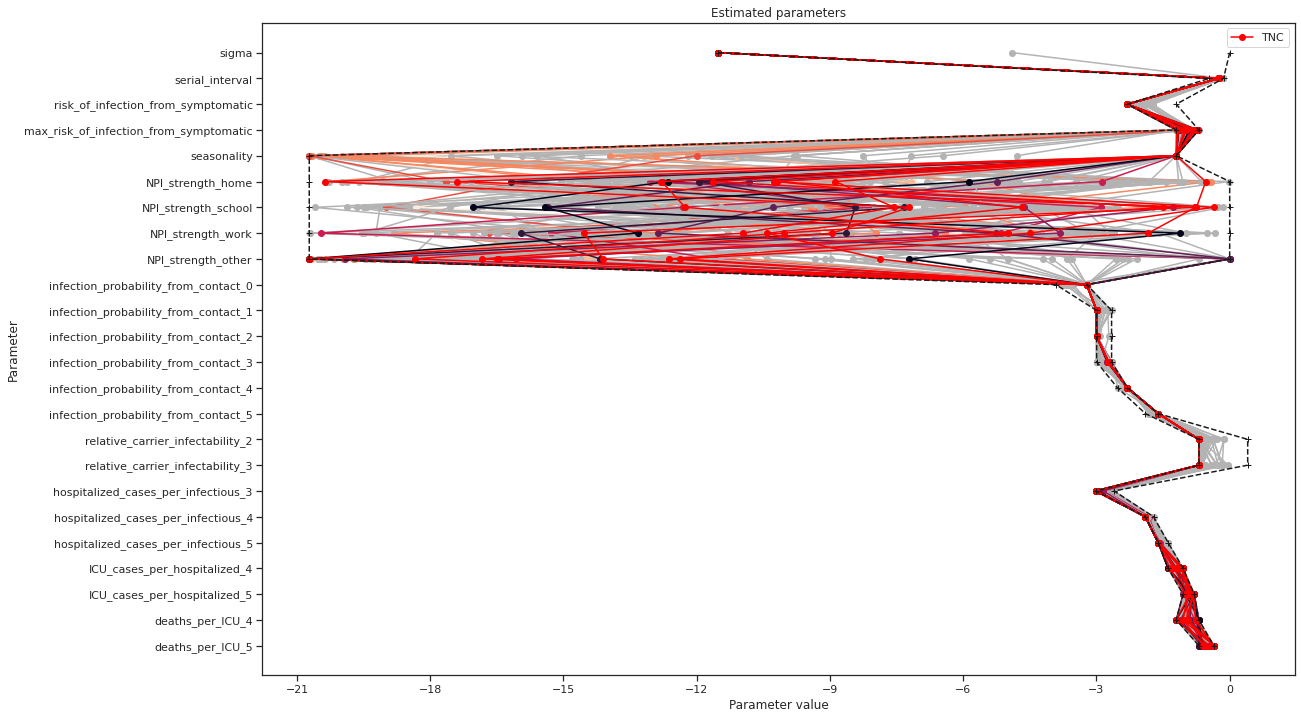

In [82]:
ax = visualize.parameters(
    [result],
    legends=["TNC"],
    balance_alpha=False,
)
ax.set_yticklabels(['sigma']+varying_input_factors)
ax.tick_params(axis='y', rotation=0)
#ax.set_yticklabels(varying_input_factors, rotation=90)

In [83]:
sample.geweke_test(result = result)
result.sample_result['burn_in']

Geweke burn-in index: 0


0

In [53]:
sample.effective_sample_size(result=result)
result.sample_result['effective_sample_size']

Estimated chain autocorrelation: 1172.8374145477621
Estimated effective sample size: 8.519919263140057


8.519919263140057

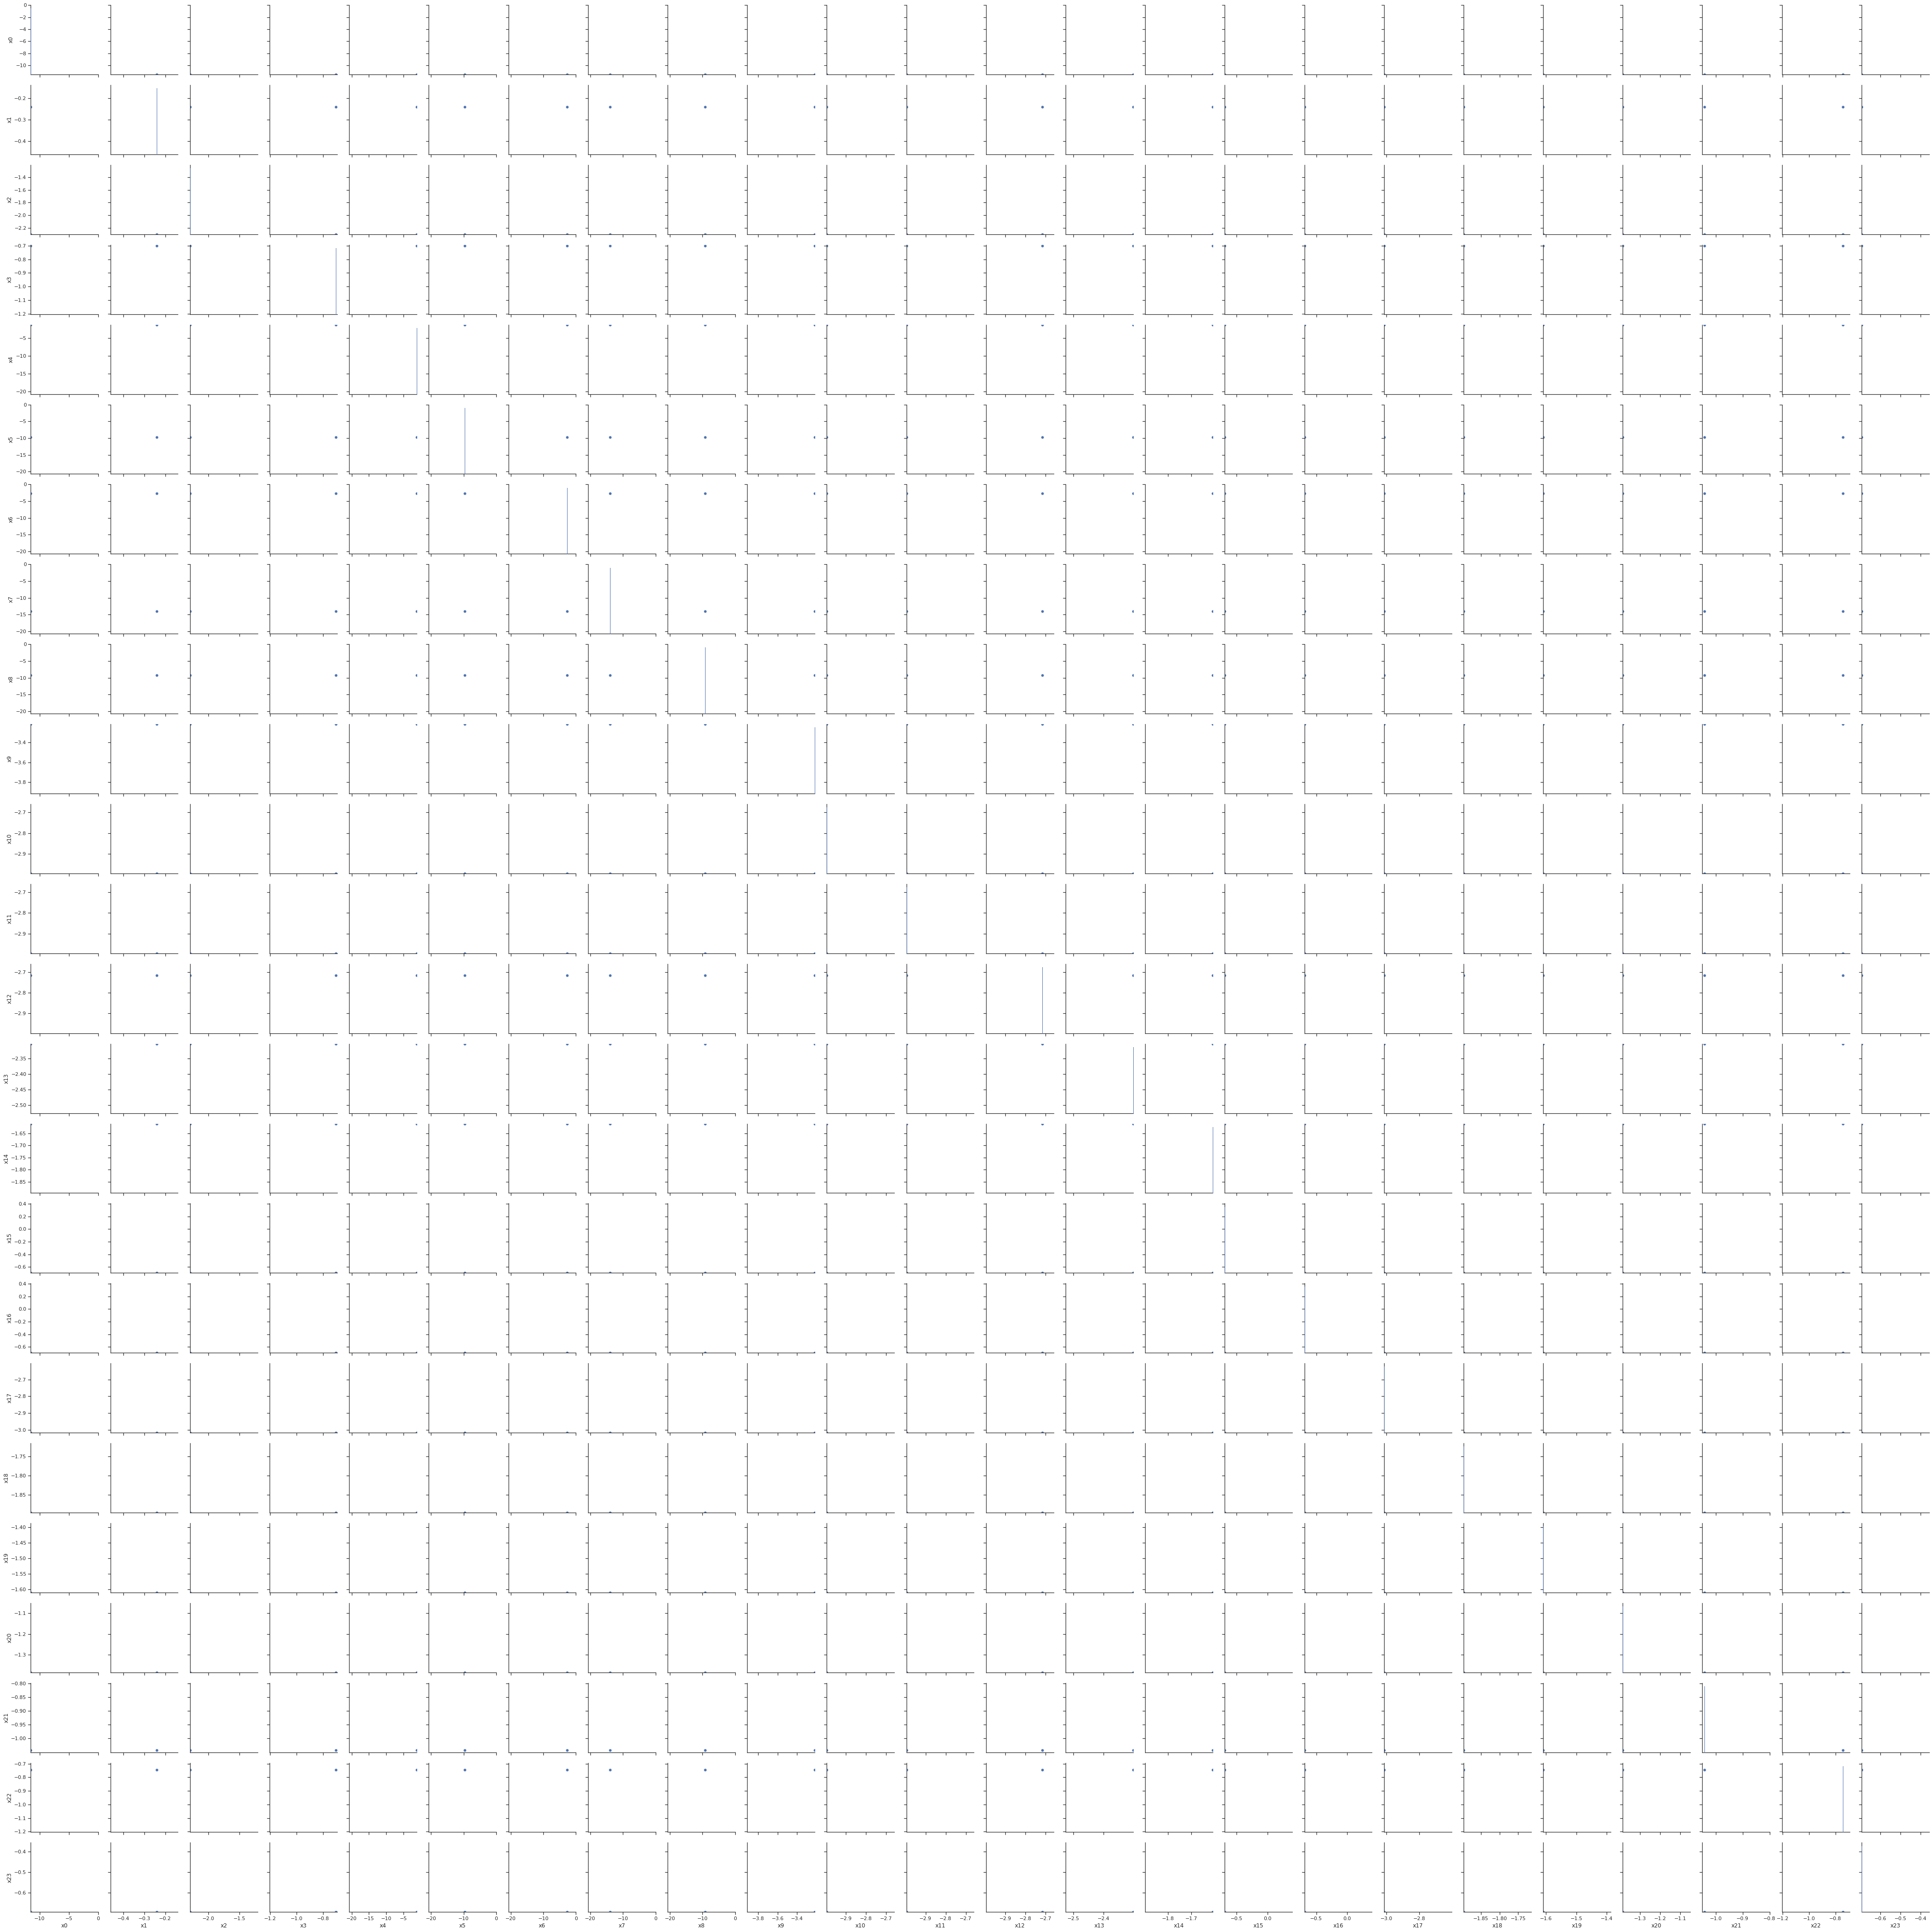

In [60]:
ax = visualize.sampling_scatter(result)
plt.savefig("plots/sample_scatter.png")

In [ ]:
def sampling_1d_marginals_(
    result: Result,
    i_chain: int = 0,
    par_indices: Sequence[int] = None,
    stepsize: int = 1,
    plot_type: str = 'both',
    bw_method: str = 'scott',
    suptitle: str = None,
    size: Tuple[float, float] = None,
):
    """
    Plot marginals.

    Parameters
    ----------
    result:
        The pyPESTO result object with filled sample result.
    i_chain:
        Which chain to plot. Default: First chain.
    par_indices: list of integer values
        List of integer values specifying which parameters to plot.
        Default: All parameters are shown.
    stepsize:
        Only one in `stepsize` values is plotted.
    plot_type: {'hist'|'kde'|'both'}
        Specify whether to plot a histogram ('hist'), a kernel density estimate
        ('kde'), or both ('both').
    bw_method: {'scott', 'silverman' | scalar | pair of scalars}
        Kernel bandwidth method.
    suptitle:
        Figure super title.
    size:
        Figure size in inches.

    Return
    --------
    ax:
        matplotlib-axes
    """
    # get data which should be plotted
    nr_params, params_fval, theta_lb, theta_ub, param_names = get_data_to_plot(
        result=result,
        i_chain=i_chain,
        stepsize=stepsize,
        par_indices=par_indices,
    )

    # compute, how many rows and columns we need for the subplots
    num_row = int(np.round(np.sqrt(nr_params)))
    num_col = int(np.ceil(nr_params / num_row))

    fig, ax = plt.subplots(num_row, num_col, squeeze=False, figsize=size)

    par_ax = dict(zip(param_names, ax.flat))
    sns.set(style="ticks")

    # fig, ax = plt.subplots(nr_params, figsize=size)[1]
    for idx, par_id in enumerate(param_names):
        if plot_type == 'kde':
            # bw_method argument is deprecated... FutureWarning:
            # The `bw_method` parameter is deprecated in favor of
            # `bw_method` and `bw_adjust`.
            # TODO: add bw_adjust as option?
            sns.kdeplot(
                params_fval[par_id], bw_method=bw_method, ax=par_ax[par_id]
            )
        elif plot_type == 'hist':
            # fixes usage of sns distplot which throws a future warning
            sns.histplot(
                x=params_fval[par_id], ax=par_ax[par_id], stat='probability'
            )
            sns.rugplot(x=params_fval[par_id], ax=par_ax[par_id])
        elif plot_type == 'both':
            sns.histplot(
                x=params_fval[par_id],
                kde=True,
                ax=par_ax[par_id],
                stat='probability',
            )
            sns.rugplot(x=params_fval[par_id], ax=par_ax[par_id])

        par_ax[par_id].set_xlabel(param_names[idx])
        par_ax[par_id].set_ylabel('Density')

    sns.despine()

    if suptitle:
        fig.suptitle(suptitle)

    fig.tight_layout()

    return ax

In [72]:
nr_params = len(varying_input_factors)+1
num_row = int(np.round(np.sqrt(nr_params)))
num_col = int(np.ceil(nr_params / num_row))

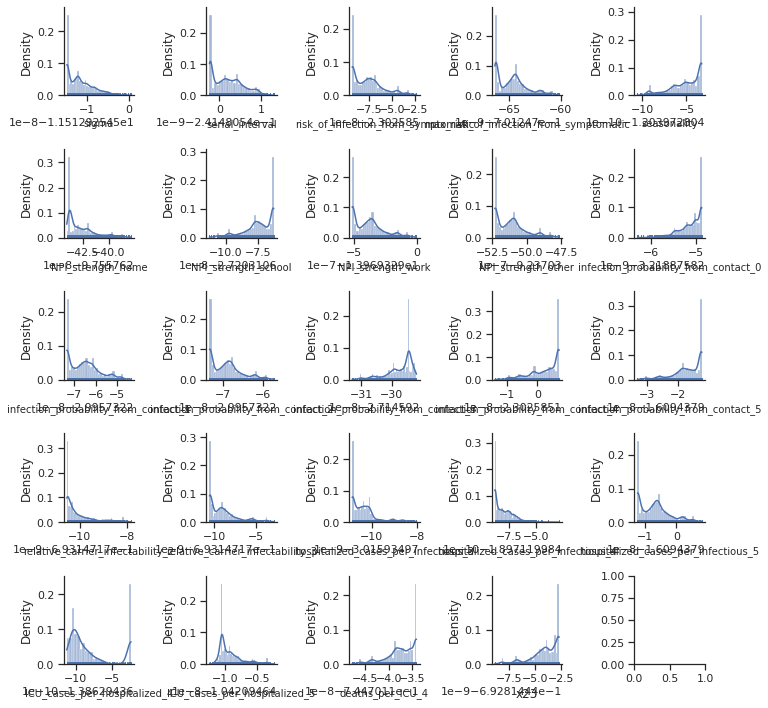

In [77]:
#fig, ax = plt.subplots(num_row, num_col, squeeze=False, figsize=size)
ax = visualize.sampling_1d_marginals(result, size =(10,10))
k = 0
for i in range(num_row):
    for j in range(num_col):
        if k < nr_params:
            ax[i,j].set_xlabel((['sigma']+varying_input_factors)[k], fontsize=10)
            k += 1

best values:  [7.85464089e-01 1.00000000e-01 4.95966415e-01 3.00000000e-01
 5.79597104e-05 6.58542928e-02 8.57427242e-07 9.73658298e-05
 4.00000000e-02 5.00000000e-02 5.00000000e-02 6.62319506e-02
 1.00000000e-01 2.00000000e-01 5.00000000e-01 5.00000000e-01
 4.90000000e-02 1.50000000e-01 2.00000000e-01 2.50000000e-01
 3.52715093e-01 4.74876203e-01 5.00166397e-01]
(51, 3)
[2022-09-05 08:17:41.202] [info] Adaptive step sizing successful to tolerances.


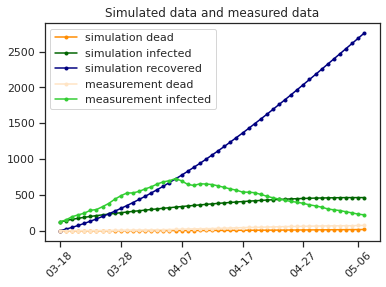

In [57]:
best_values = np.exp(result.optimize_result.as_list()[0]['x'][1:])
print("best values: ", best_values)
static_params['output_index'] = [Compartments.index("Dead"), Compartments.index("Infected"), Compartments.index("Recovered")]
simulation = simulate_model({**static_params, **dict(zip(varying_input_factors, best_values)), **dict_fixed_factors})
print(simulation.shape)

datelist = np.array(pd.date_range(datetime(start_year, start_month,
                        start_day), periods=days, freq='D').strftime('%m-%d').tolist())

tick_range = (np.arange(int(days / 10) + 1) * 10)
tick_range[-1] -= 1
fig, ax = plt.subplots()
ax.plot(simulation[:, 0], 'o-', markersize = 3, label='simulation dead', color="darkorange") 
ax.plot(simulation[:, 1], 'o-', markersize = 3, label='simulation infected', color="darkgreen") 
ax.plot(simulation[:, 2], 'o-', markersize = 3, label='simulation recovered', color="navy") 
ax.plot(dead_cases, 'o-', markersize = 3, label='measurement dead', color = "bisque")
ax.plot(infected_cases, 'o-', markersize = 3, label='measurement infected', color = "limegreen")
#ax.plot(recovered_cases, 'o-', markersize = 3, label='measurement recovered', color = "royalblue")
ax.set_title("Simulated data and measured data")
ax.set_xticks(tick_range)
ax.set_xticklabels(datelist[tick_range], rotation=45)
ax.legend()
fig.tight_layout
plt.show()
#fig.savefig('plots/'+ time.strftime("%Y-%m-%d %H%M%S") + '_Plot_best_simulation.pdf')
#plt.close()